### pretrained SSD model
https://github.com/pierluigiferrari/ssd_keras

In [1]:
import os
orig_path = os.getcwd()
os.chdir('ssd_keras')

In [57]:
import cv2
import numpy as np
import json


from matplotlib import pyplot as plt
import pafy
import time
import copy
from scipy.spatial import distance
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
# from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
# from keras_layers.keras_layer_DecodeDetections import DecodeDetections
# from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
# from keras_layers.keras_layer_L2Normalization import L2Normalization
%matplotlib inline

In [ ]:
# Set the image size.
img_height = 512
img_width = 512

In [ ]:
model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 128, 256, 512],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

### Load the pre-trained SSD weights

In [ ]:
weights_path = 'VGG_VOC0712_SSD_512x512_iter_120000.h5'
classes = ['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
           'chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
           'sheep','sofa','train','tvmonitor']
model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### Test image

In [ ]:
img_path = 'examples/test.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
orig_img = np.copy(img)
img = cv2.resize(img,(img_height, img_width))
img = np.expand_dims(img,0)

In [ ]:
orig_img.shape

In [ ]:
# %%time
result = model.predict(img)
confidence_threshold = 0.5

result_thresh = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
# print(result_thresh[0])
width_fix_factor = orig_img.shape[1]/img_width
height_fix_factor = orig_img.shape[0]/img_height

In [ ]:
track_history = {}
current_centroids = []

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

idx = 1
for r in result_thresh[0]:
    if r[0] == 15: # person
        xmin = int(r[2] * width_fix_factor)
        ymin = int(r[3] * height_fix_factor)
        xmax = int(r[4] * width_fix_factor)
        ymax = int(r[5] * height_fix_factor)
        cent = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
        tl = (xmin,ymin)
        br = (xmax,ymax)
        cv2.rectangle(img,tl,br,(0,0,255),thickness=2)
        current_centroids.append(cent)
        
        track_history[idx] = [cent]

        idx += 1
        
print('current: {}'.format(current_centroids))
print('history: {}'.format(track_history))

for centroid in current_centroids:
    cv2.circle(img,centroid,10,(255,0,0),cv2.FILLED)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')

In [ ]:
img.shape

#### testing code - tracking the same object

In [ ]:
min_dist_thresh = 50
sample_list = [(3,7),(10,10),(15,15)]
sample_dict = {1:[(2,3),(3,6)],2:[(8,3),(8,6)],3:[(4,3),(4,6)]}
sample_dict_temp = copy.deepcopy(sample_dict)
print(sample_dict_temp)
print(sample_dict)
for cent in sample_list:
    min_dist = min_dist_thresh
    min_label = None
    for label,pos in sample_dict.items():
        dist = distance.euclidean(cent,pos[-1])
        if dist<min_dist:
            min_dist = dist
            min_label = label
    sample_dict_temp[min_label].append(cent)

In [ ]:
print(sample_dict) # should not be altered
print(sample_dict_temp)

In [ ]:
distance.euclidean((4,5),(4,5)) == 0

In [ ]:
test_list_1 = [4,2,3,5,10,11]
history_2 = {5:[5],4:[4],3:[3]}

test_list_1_temp = copy.deepcopy(test_list_1)
history_2_temp = copy.deepcopy(history_2)
history_2_key_temp = copy.deepcopy(list(history_2.keys()))
print('final list',test_list_1_temp)
print('final history key', history_2_key_temp)

In [ ]:
for tl_1 in test_list_1:
    print('tl_1: ', tl_1)
    min_dist = 0.5 # reset min_ variables for each current centroid
    min_idx = None
    print('history key', history_2_key_temp)
    for idx in history_2_key_temp:
        print('idx: ',idx)
        dist = distance.euclidean(tl_1,history_2[idx][-1])
        if dist<min_dist:
            min_dist = dist
            min_idx = idx
            print('dist: ', min_dist)

    if min_idx is not None:
        ## if moved
        history_2_temp[min_idx].append(tl_1) ## update the history_temp by appending
        test_list_1_temp.remove(tl_1)
        history_2_key_temp.remove(min_idx)

    #min_label is NONE --> NEW VALUE
    else: 
        pass
#         test_list_1_temp.remove(tl_1)
    print('\n')

print('final list',test_list_1_temp)
print('final history key', history_2_key_temp)

In [ ]:
a = [1,2,3,4,5,6]

In [ ]:
a[:-3]

In [ ]:
url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ'

img_width = 512
img_height = 512

pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

ret,frame = cap.read()
if ret == True:
    frame = np.asarray(frame)
    sample_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
cap.release()

width_fix_factor = width/img_width
height_fix_factor = height/img_height

print('frame #',length)
print('width',width)
print('height',height)

In [ ]:
print('processing ongoing',end='')
frame_count = 0
skip_frame = 10
min_dist_thresh = 50
removing_thresh = 10
confidence_threshold = 0.25

url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ'

pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

if (cap.isOpened() == False):
    print('cannot read a video')
    
track_history = {}
moving_tracker = {}
archive = {}
idx = 1 ## customer id

while cap.isOpened():
    ret,frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
#         orig_frame = np.copy(frame)
        frame = cv2.resize(frame,(img_height,img_width)) #resize for SSD
        frame = np.expand_dims(frame,0)
        
        if frame_count % skip_frame == 0: #every 10 frames
            current_centroids = [] #reset current centroid list at every frame
            
            ## if track_history is empty 
            if not track_history:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
                ## at least one person on the scene
                
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        track_history[idx] = [centroid] # add the list of positions
                        moving_tracker[idx] = 0 ################################ initialize moving racker
                        idx += 1
#                         print('when empty: dict {}'.format(track_history)) #######################################
#                         print('when empty: moving_tracker {}'.format(moving_tracker))

            ## after persons are detected and track_history is created
            else:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
    
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        current_centroids.append(centroid)
#                 print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                ## compare and update
                current_centroids_temp = copy.deepcopy(current_centroids)
                track_history_temp = copy.deepcopy(track_history)
                track_history_key_temp = copy.deepcopy(list(track_history.keys()))
                                    
                ## original stays unchanged
                for cent in current_centroids:
                    min_dist = min_dist_thresh # reset min_ variables for each current centroid
                    min_label = None
                    for label in track_history_key_temp:
                        dist = distance.euclidean(cent,track_history_temp[label][-1])
                        if dist<min_dist:
                            min_dist = dist
                            min_label = label 
                            
                    # for same label centroid
                    if min_label is not None:
                        if min_dist == 0: ##if object not moved, increase the moving tracker counter by 1
                            moving_tracker[min_label] += 1
                        else: ## if moved, reset the tracker counter
                            moving_tracker[min_label] = 0
                        ## if moved
                        track_history_temp[min_label].append(cent) ## update the history_temp by appending
                        current_centroids_temp.remove(cent)
                        track_history_key_temp.remove(min_label)
                               
                    #min_label is NONE --> NEW VALUE
                    else: 
                        track_history_temp[idx] = [cent]
                        moving_tracker[idx] = 0
#                         current_centroids_temp.remove(cent)
                        idx += 1
                ## object hidden or exit
                if track_history_key_temp: 
                    for left_over in track_history_key_temp:
                        moving_tracker[left_over] += 1
                        track_history_temp[left_over].append(track_history_temp[left_over][-1])
                
#                 ## new person comes in the scene       
#                 if current_centroids_temp: #if current centroid temp is not empty
#                     print('this is ever running?!?!')
#                     idx += 1
#                     for left_over in current_centroids_temp:
#                         track_history_temp[idx] = left_over ## add new objects to the track
                   

                track_history = track_history_temp # update the history

#                 print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
#                 print('moving tracker: {}'.format(moving_tracker))
#                 print('\n')
        
    
            ## move the unmoving objects to the archive dictionary
            moving_tracker_temp = copy.deepcopy(moving_tracker)
            for obj,counter in moving_tracker_temp.items():
                if counter == removing_thresh:
                    archive[obj] = track_history[obj][:-removing_thresh]
                    del track_history[obj]
                    del moving_tracker[obj]

#             print('archieve: {}'.format(archive))
            print('.',end='')
#         cv2.imshow('frame',frame)
        frame_count += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            break  
    else:
        break
# cv2.destroyAllWindows()
cap.release()
# out.release() 

#after all, move all to archive
moving_tracker_temp = copy.deepcopy(moving_tracker)
for obj,counter in moving_tracker_temp.items():
    archive[obj] = track_history[obj][:-removing_thresh]
    del track_history[obj]
    del moving_tracker[obj]

In [ ]:
print('frame #',length )
print('width',width)
print('height',height)

In [ ]:
len(archive)

In [ ]:
pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

ret,frame = cap.read()

if ret == True:
    frame = np.asarray(frame)
#         orig_frame = np.copy(frame)
    img_before_resize = frame
    frame = cv2.resize(frame,(img_height,img_width))
    img_after_resize = frame


cap.release()

In [ ]:
testing = copy.deepcopy(archive)

In [ ]:
json.dump(testing, open("testing.txt",'w'))

In [58]:
# read
testing = json.load(open("testing.txt"))

In [60]:
len(testing)

44

In [61]:
sorted_testing = {}
for key in sorted(testing.keys()):
    sorted_testing[key]=testing[key]

In [62]:
len(sorted_testing)

44

In [77]:
url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ'

pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

_, img = cap.read()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
average_img = np.float32(img) 
  
while cap.isOpened():
    ret,img = cap.read() 
    if ret == True:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        cv2.accumulateWeighted(img, average_img, 0.005)   
        background = cv2.convertScaleAbs(average_img) 
    else:
        break
cap.release()    

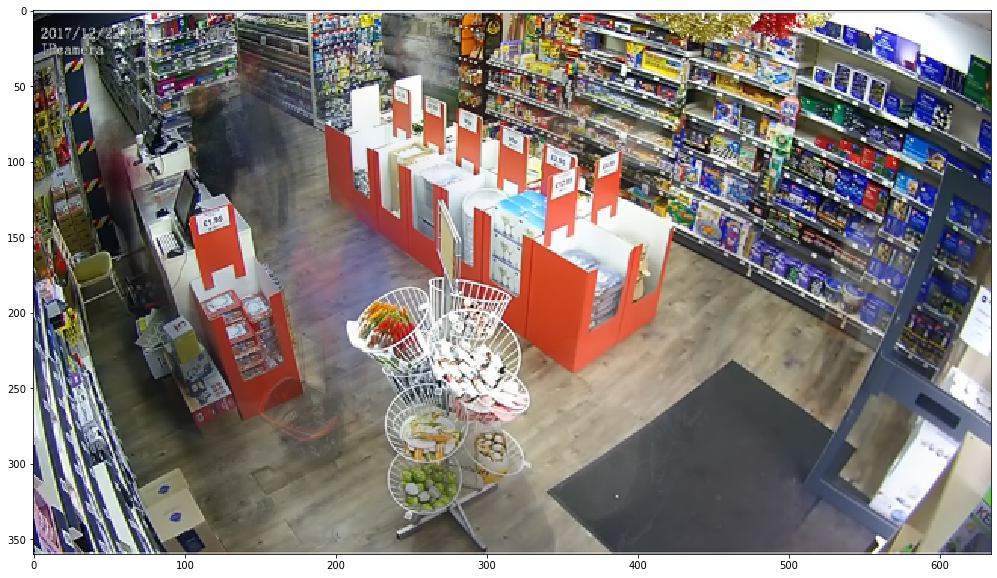

In [51]:
#0.005
plt.figure(figsize=(20,10))
plt.imshow(resultingFrames1)

In [86]:
import seaborn as sns

In [ ]:
    ax.jointplot(x,y,kind='scatter')



In [95]:
len(sorted_testing.values())

44

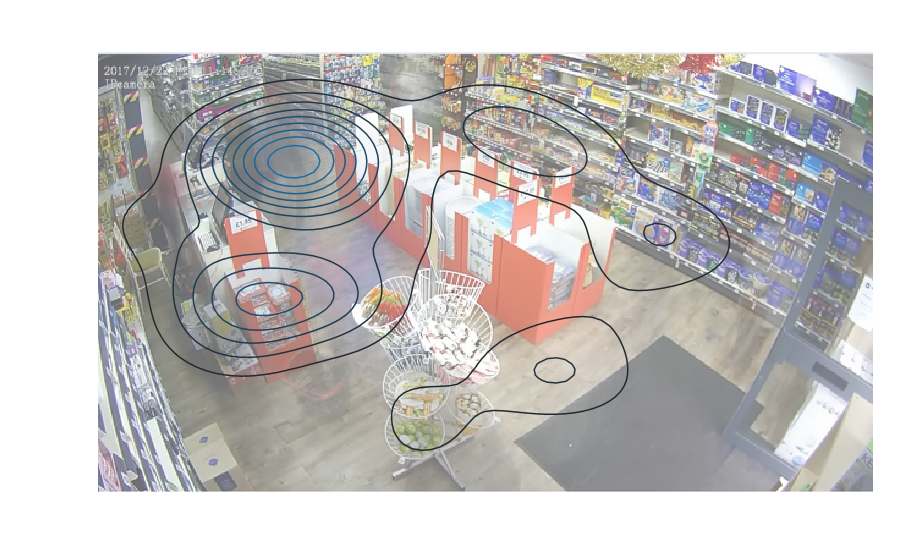

In [169]:
xx = []
yy = []
for key in sorted_testing.keys():
    for centroid in sorted_testing[key]:
        xx.append(centroid[0])
        yy.append(centroid[1])

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(background,alpha=0.6,cmap='gray')
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
for key in sorted_testing.keys():
    x = []
    y = []
    for centroid in sorted_testing[key]:
        x.append(centroid[0])
        y.append(centroid[1])
#     sns.scatterplot(x,y,ax=ax,alpha=0.3,s=200)
sns.kdeplot(xx,yy,ax=ax,n_levels=10)
    
plt.axis('off')
plt.show()

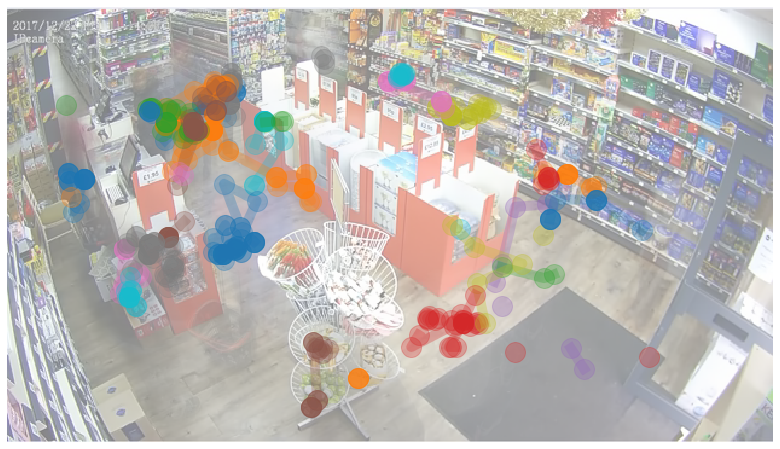

In [162]:
plt.figure(figsize=(15,8))
ax = plt.gca()
plt.imshow(background,alpha=0.5,cmap='gray')
for key in sorted_testing.keys():
    x = []
    y = []
    for centroid in sorted_testing[key]:
        x.append(centroid[0])
        y.append(centroid[1])
    ax.plot(x,y,marker='o',alpha=0.3,markersize=20,lw=10)
plt.axis('off')
plt.show()

### previous working version

In [ ]:
frame_count = 0
skip_frame = 10
min_dist_thresh = 50
confidence_threshold = 0.5

url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ'

pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

if (cap.isOpened() == False):
    print('cannot read a video')
    
track_history = {}
archive = {}
idx = 1 ## customer id

while cap.isOpened():
    ret,frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
#         orig_frame = np.copy(frame)
        frame = cv2.resize(frame,(img_height,img_width)) #resize for SSD
        frame = np.expand_dims(frame,0)
        
        if frame_count % skip_frame == 0: #every 10 frames
            current_centroids = [] #reset current centroid list at every frame
            
            ## if track_history is empty 
            if not track_history:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
                ## at least one person on the scene
                
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         print('when empty {}'.format(centroid)) #######################################
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        track_history[idx] = [centroid] # add the list of positions
                        idx += 1
#                 print('when empty dict {}'.format(track_history)) #######################################
            
            ## after persons are detected and track_history is created
            else:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
    
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        current_centroids.append(centroid)
                print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                ## compare and update
                current_centroids_temp = copy.deepcopy(current_centroids)
                track_history_temp = copy.deepcopy(track_history)
                track_history_key_temp = copy.deepcopy(list(track_history.keys()))
                
#                 if len(current_centroids_temp) == len(track_history_temp): ## normal situation
                    
                ## original stays unchanged therefore use for looping
                for cent in current_centroids:
                    min_dist = min_dist_thresh
                    min_label = None 
                    for label,pos in track_history.items():
                        dist = distance.euclidean(cent,pos[-1])
                        if dist<min_dist:
                            min_dist = dist
                            min_label = label 
                            
                    # for same label centroid
                    if min_label is not None:
                        track_history_temp[min_label].append(cent) ## update the history by appending
                        current_centroids_temp.remove(cent)
                        track_history_key_temp.remove(min_label)
                    else: #min_label is NONE --> NEW VALUE
                        track_history_temp[idx] = [cent]
                        current_centroids_temp.remove(cent)
                        idx += 1

                if track_history_key_temp:
                    for left_over in track_history_key_temp:     
                        track_history_temp[left_over].append(track_history_temp[left_over][-1]) 
                        
                if current_centroids_temp: #if current centroid temp is not empty
                    idx += 1
                    for left_over in current_centroids_temp:
                        track_history_temp[idx] = left_over ## add new objects to the track
                   

                track_history = track_history_temp

                
#                 elif len(current_centroids) > len(track_history): ## new person comes in the scene
#                     for cent in current_centroids:
#                         min_dist = min_dist_thresh
#                         min_label = None
#                         for label,pos in track_history_temp.items():
#                             dist = distance.euclidean(cent,pos[-1])
#                             if dist<min_dist:
#                                 min_dist = dist
#                                 min_label = label
#                         track_history[min_label].append(cent) ## update the history
#                         current_centroids_temp.remove(cent)
#                     for left_over in current_centroids_temp:
#                         track_history[idx+1] = left_over ## add new objects to the track
                
#                 else: # object hidden or exit
#                     for cent in current_centroids:
#                         min_dist = min_dist_thresh
#                         min_label = None
#                         for label,pos in track_history_temp.items():
#                             dist = distance.euclidean(cent,pos[-1])
#                             if dist<min_dist:
#                                 min_dist = dist
#                                 min_label = label
#                         track_history[min_label].append(cent) ## update the history
#                         track_history_key_temp.remove(min_label)
#                     for left_over in track_history_key_temp:
#                         track_history[left_over].append(track_history[left_over][-1])
                print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
                print('\n')
        
#         cv2.imshow('frame',frame)
        frame_count += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            break  
    else:
        break
# cv2.destroyAllWindows()
cap.release()
# out.release() 


'''
need to work on the archive
'''